In [91]:
# Max Boving
# ISTA 350 Final Project
# Scraping OEWS national data and visualizing job trends


import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns


In [92]:
HEADERS = {"User-Agent": "UA-Student-Scraper/1.0"}

soc_code_pattern = re.compile(r"^\d{2}-\d{4}$")

def to_num(s: str):
    """Convert strings like '1,234', '$25.50', '1.5%' to float; return None for blanks/dashes; keep text if not numeric."""
    if s is None:
        return None
    s = s.replace(",", "").replace("$", "").replace("%", "").strip()
    if s in {"", "—", "–", "-"}:
        return None
    try:
        return float(s)
    except ValueError:
        return s

def norm(h: str):
    """Normalize header text to snake_case keys."""
    return (h.lower()
              .replace("(", "")
              .replace(")", "")
              .replace("/", "_")
              .replace(",", "")
              .replace(" ", "_"))

def fetch_html(url, headers=HEADERS, timeout=20, retries=3, pause=1.0):
    """Fetch with simple retries."""
    last_err = None
    for _ in range(retries):
        try:
            r = requests.get(url, headers=headers, timeout=timeout)
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            time.sleep(pause)
    raise last_err


In [93]:
def find_oews_table(soup):
    # grab the table that has occupation code and title in the header row
    for table in soup.find_all("table"):
        header_row = table.find("tr")
        if header_row is None:
            continue
        header_text = header_row.get_text(" ", strip=True).lower()
        if "occupation code" in header_text and "occupation title" in header_text:
            return table

    return None


def scrape_oews_year(year):
    # scrape one OEWS national page for a single year
    url = f"https://www.bls.gov/oes/{year}/may/oes_nat.htm"
    html = fetch_html(url)
    soup = BeautifulSoup(html, "html.parser")

    table = find_oews_table(soup)

    ### rows == tr
    rows = table.find_all("tr")
    if len(rows) == 0:
        return pd.DataFrame()

    # header row figure out which column is which
    header_cells = rows[0].find_all(["th"])
    headers = [c.get_text(" ", strip=True).lower() for c in header_cells]

    def find_col(keyword):
        keyword = keyword.lower()
        for i, h in enumerate(headers):
            if keyword in h:
                return i
        return None

    code_idx        = find_col("occupation code")
    title_idx       = find_col("occupation title")
    emp_idx         = find_col("employment")
    median_hr_idx   = find_col("median hourly")
    mean_hr_idx     = find_col("mean hourly")
    annual_mean_idx = find_col("annual mean")

    data = []

    # go through each data row (skip header)
    for row in rows[1:]:
        cells = row.find_all("td")
        if len(cells) == 0:
            continue

        code_text = cells[code_idx].get_text(strip=True)

        # keep only real SOC codes using the regex structure
        if not soc_code_pattern.match(code_text):
            continue

        title_text = cells[title_idx].get_text(" ", strip=True)

        # build one row of data
        record = {
            "year": year,
            "occupation_code": code_text,
            "occupation_title": title_text,
            "employment": to_num(cells[emp_idx].get_text(strip=True)),
            "median_hourly_wage": to_num(
                cells[median_hr_idx].get_text(strip=True)),
            "mean_hourly_wage": to_num(
                cells[mean_hr_idx].get_text(strip=True)),
            "annual_mean_wage": to_num(
                cells[annual_mean_idx].get_text(strip=True))}

        data.append(record)
    #  return dataframe
    return pd.DataFrame(data)


In [94]:
YEARS = [2019, 2020, 2021, 2022, 2023]  

dfs = []

for y in YEARS:
    # run scraper for each year
    dfy = scrape_oews_year(y) 
    # store the result
    dfs.append(dfy)               
    print(f"Scraped {y}: {dfy.shape}")
# stack all years into one dataframe
df_all = pd.concat(dfs, ignore_index=True)
print("\nCombined:", df_all.shape)

df_all.head(10)


Scraped 2019: (1040, 7)
Scraped 2020: (1040, 7)
Scraped 2021: (1105, 7)
Scraped 2022: (1104, 7)
Scraped 2023: (1105, 7)

Combined: (5394, 7)


,year,occupation_code,occupation_title,employment,median_hourly_wage,mean_hourly_wage,annual_mean_wage
0,2019,00-0000,All Occupations,146875480.0,19.14,25.72,53490.0
1,2019,11-0000,Management Occupations,8054120.0,50.8,58.88,122480.0
2,2019,11-1000,Top Executives,2658440.0,49.63,61.09,127070.0
3,2019,11-1011,Chief Executives,205890.0,88.68,93.2,193850.0
4,2019,11-1021,General and Operations Managers,2400280.0,48.45,59.15,123030.0
5,2019,11-1031,Legislators,52280.0,(4),(4),49440.0
6,2019,11-2000,"Advertising, Marketing, Promotions, Public Rel...",770540.0,61.96,68.91,143330.0
7,2019,11-2011,Advertising and Promotions Managers,25100.0,60.34,68.22,141890.0
8,2019,11-2020,Marketing and Sales Managers,666280.0,62.84,69.55,144660.0
9,2019,11-2021,Marketing Managers,263680.0,65.79,71.73,149200.0


# Figure 1: Top 6 Occupations by employment(workforce size)

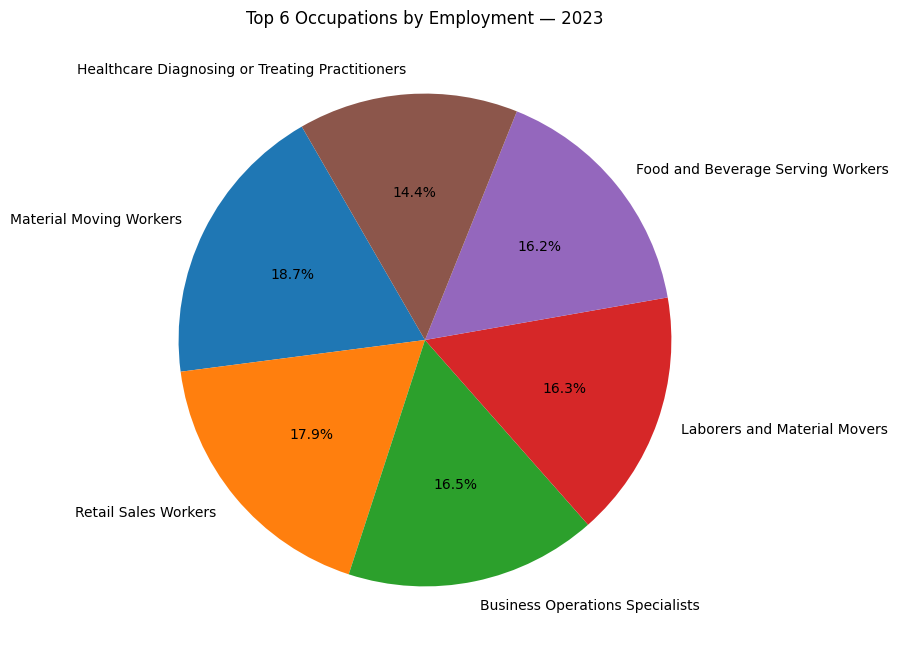

In [95]:
# most recent year in the dataset
latest_year = df_all["year"].max()

# only use rows from that year
year_data = df_all[df_all["year"] == latest_year]

# drop rows where employment is missing
year_data = year_data.dropna(subset=["employment"])

# remove total rows (00-0000 and major group codes ending in 0000)
year_data = year_data[year_data["occupation_code"] != "00-0000"]
year_data = year_data[~year_data["occupation_code"].str.endswith("0000")]

# take the top 6 occupations by employment count
year_data = year_data.sort_values(by="employment", ascending=False)
# grab top 6
top6 = year_data.head(6)
# plot the pie chart
plt.figure(figsize=(10,8))
plt.pie(
    top6["employment"],
    labels=top6["occupation_title"],
    autopct="%1.1f%%",
    startangle=120
)
plt.title(f"Top 6 Occupations by Employment — {latest_year}")
plt.show()


In [96]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# small df with just what we need for next two vis 
df_wage = df_all[["year", "occupation_title", "annual_mean_wage"]].copy()

# make sure wage is numeric
df_wage["annual_mean_wage"] = pd.to_numeric(df_wage["annual_mean_wage"], errors="coerce")

# drop rows with no wage
df_wage = df_wage.dropna(subset=["annual_mean_wage"])
df_wage


,year,occupation_title,annual_mean_wage
0,2019,All Occupations,53490.0
1,2019,Management Occupations,122480.0
2,2019,Top Executives,127070.0
3,2019,Chief Executives,193850.0
4,2019,General and Operations Managers,123030.0
...,...,...,...
5389,2023,"Pump Operators, Except Wellhead Pumpers",58650.0
5390,2023,Wellhead Pumpers,69930.0
5391,2023,Refuse and Recyclable Material Collectors,47810.0
5392,2023,"Tank Car, Truck, and Ship Loaders",60530.0


# Figure 2 : Box-plot of Highest Annual Mean Wage per Job (2019-2023)

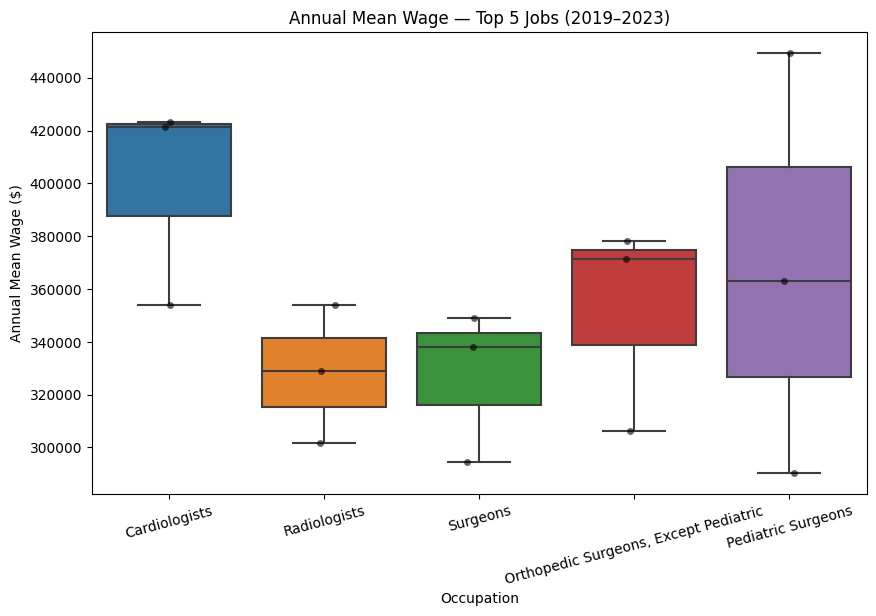

In [97]:
# last 5 years in the data
years_window = sorted(df_wage["year"].unique())[-5:]
latest_year = years_window[-1]

# data for most recent year
recent = df_wage[df_wage["year"] == latest_year]

# pick top 5 highest-paying job titles
top5_titles = (
    recent.sort_values("annual_mean_wage", ascending=False)
    .head(5)["occupation_title"]
    .tolist()
)

# keep only those titles across the 5-year window
df_top5 = df_wage[
    (df_wage["occupation_title"].isin(top5_titles)) &
    (df_wage["year"].isin(years_window))
].copy()

# boxplot + jitter points
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top5, x="occupation_title", y="annual_mean_wage")
sns.stripplot(
    data=df_top5,
    x="occupation_title",
    y="annual_mean_wage",
    color="black",
    alpha=0.6,
    jitter=0.08
)

plt.title(f"Annual Mean Wage — Top 5 Jobs ({years_window[0]}–{years_window[-1]})")
plt.xlabel("Occupation")
plt.ylabel("Annual Mean Wage ($)")
plt.xticks(rotation=15)
plt.show()


# Figure 3 : Data related job wage trends over past 5 years

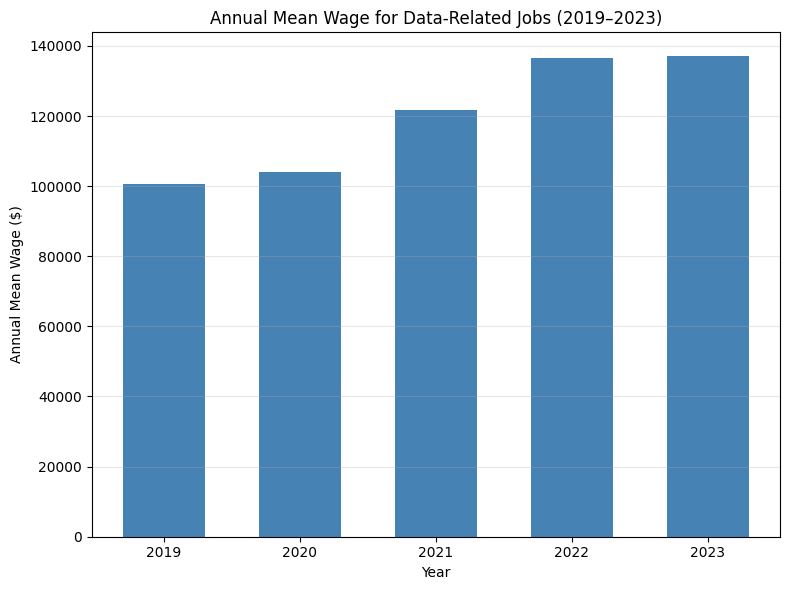

In [98]:

# only keep rows where the title contains data
sub = df_wage[df_wage["occupation_title"].str.contains("Data", case=False, na=False)].copy()
#print(sub)
# sort by year so the bar chart goes in order
sub = sub.sort_values("year")

# bar chart of wage progression
plt.figure(figsize=(8,6))
plt.bar(
    sub["year"].astype(int),
    sub["annual_mean_wage"],
    color="steelblue",
    width=0.6
)

plt.title("Annual Mean Wage for Data-Related Jobs (2019–2023)")
plt.xlabel("Year")
plt.ylabel("Annual Mean Wage ($)")
plt.xticks(sub["year"].unique())
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 4: Scatterplot with regression depicting positive relationship between annual and hourly wage

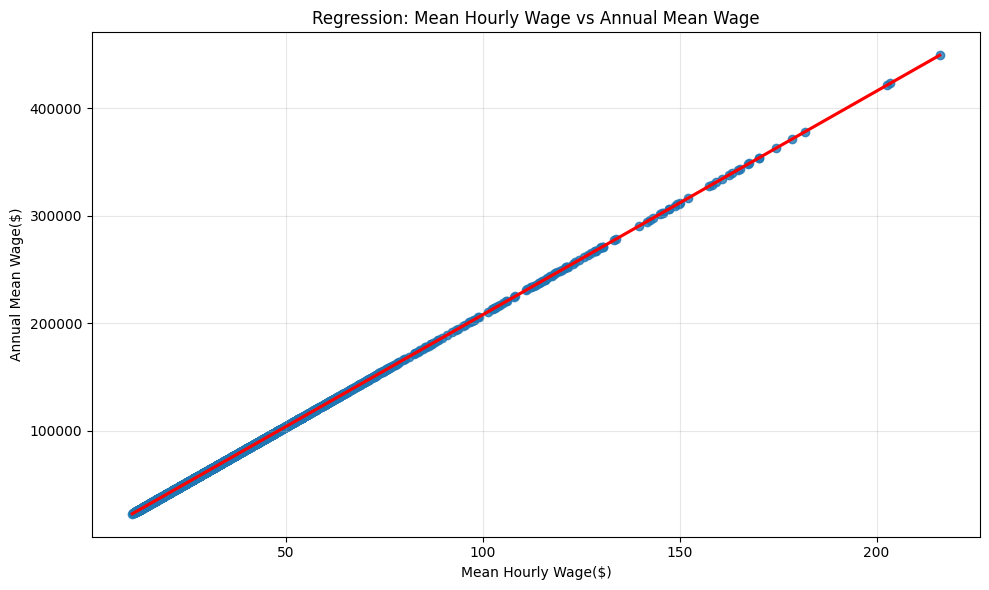

In [117]:
cols = ["median_hourly_wage", "mean_hourly_wage", "annual_mean_wage"]

for c in cols:
    df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

df_all["employment"] = pd.to_numeric(df_all["employment"], errors="coerce")
df_all["year"] = pd.to_numeric(df_all["year"], errors="coerce")

plt.figure(figsize=(10,6))

sns.regplot(
    data=df_all,
    x="mean_hourly_wage",
    y="annual_mean_wage",
    line_kws={'color': 'red'}
)

plt.xlabel("Mean Hourly Wage($)")
plt.ylabel("Annual Mean Wage($)")
plt.title("Regression: Mean Hourly Wage vs Annual Mean Wage")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
